In [1]:
!pip install transformers

In [2]:
import ast
import csv
import itertools
import string
import sys
import time
import torch
import numpy as np
import pandas as pd 
import json
import random
import time
import ast
import argparse
from collections import defaultdict
import matplotlib.pyplot as plt

# A. Data Preprocessing

## A0. Data Preview

In [3]:
import pandas as pd
from ast import literal_eval

# Data Visualization
train = pd.read_csv("tsd_train.csv")
train["spans"] = train.spans.apply(literal_eval)
print("Train Data Example")
train.head(5)

Train Data Example


,spans,text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junio..."
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed."
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",What a knucklehead. How can anyone not know th...
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\n\nA..."


In [4]:
# Data Visualization
trial = pd.read_csv("tsd_trial.csv")
trial["spans"] = trial.spans.apply(literal_eval)
print("Test Data Example")
trial.head(5)

Test Data Example


,spans,text
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",Because he's a moron and a bigot. It's not any...
1,"[29, 30, 31, 32, 33, 34]",How about we stop protecting idiots and let na...
2,"[166, 167, 168, 169, 170, 171]","If people were smart, they would Boycott th..."
3,"[87, 88, 89, 90, 91, 92]",Trump Claimed that Russia will never invade th...
4,[],As long as your willing to pay a lot more for ...


## A1. Read Files

In [5]:
# File Directory path of the dataset
TRAIN_DIR = "tsd_train.csv"
DEV_DIR = "tsd_trial.csv"
TEST_DIR = "tsd_test.csv"

In [6]:
# Sample Code provided by SemEval 2021 Task Organziers: https://github.com/ipavlopoulos/toxic_spans
SPECIAL_CHARACTERS = string.whitespace

def _contiguous_ranges(span_list):
    """Extracts continguous runs [1, 2, 3, 5, 6, 7] -> [(1,3), (5,7)]."""
    output = []
    for _, span in itertools.groupby(
        enumerate(span_list), lambda p: p[1] - p[0]):
        span = list(span)
        output.append((span[0][1], span[-1][1]))
    return output

def fix_spans(spans, text, special_characters=SPECIAL_CHARACTERS):
    """Applies minor edits to trim spans and remove singletons."""
    cleaned = []
    for begin, end in _contiguous_ranges(spans):
        while text[begin] in special_characters and begin < end:
            begin += 1
        while text[end] in special_characters and begin < end:
            end -= 1
        if end - begin > 1:
            cleaned.extend(range(begin, end + 1))
    return cleaned

In [7]:
def read_csv_dataset(filename):
    # Read the CSV file data, provided by task organizer
    dataset = pd.read_csv(filename)

    dataset["spans"] = dataset.spans.apply(literal_eval)
    texts, spans = dataset["text"], dataset["spans"]
    texts = list(texts)
    spans = [fix_spans(span, texts[i]) for i, span in enumerate(spans)]

    return texts, spans # output both texts and spans

In [8]:
# Read the CSV files to get the texts and the spans respectively
train_texts, train_spans = read_csv_dataset(TRAIN_DIR)
val_texts, val_spans = read_csv_dataset(DEV_DIR)
test_texts, test_spans = read_csv_dataset(TEST_DIR)

# Preview
print(train_texts[10])
print(train_spans[10])
print(_contiguous_ranges(train_spans[10]))

You conveniently don't mention your cohorts who call for extermination of Jews and Blacks. With guys like IQ006, IQ22, and the rest in your corner, well, I wouldn't call you  loathsome or deplorable like them but I think " imbecile" has some merit for your selectivity.
[223, 224, 225, 226, 227, 228, 229, 230]
[(223, 230)]


## A2. Dataset Statistics

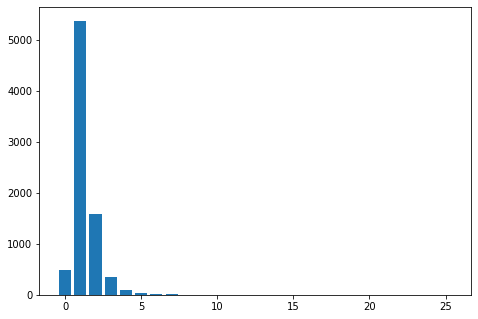

[488, 5373, 1589, 343, 92, 27, 12, 8, 4, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [9]:
# Training Dataset Statistics: showing the number of spans in one example
train_distribution = [len(_contiguous_ranges(train_spans[i])) for i in range(len(train_spans))]
train_freq=[(len([item for item in train_distribution if  i == item ])) for i in range(max(train_distribution)+1)]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([i for i in range(len(train_freq))],train_freq)
plt.show()
print(train_freq)

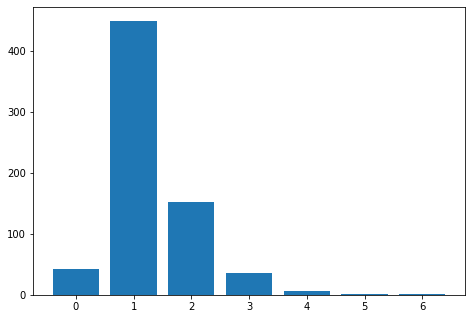

[43, 450, 153, 35, 7, 1, 1]


In [10]:
# Validation Dataset Statistics: showing the number of spans in one example
val_distribution = [len(_contiguous_ranges(val_spans[i])) for i in range(len(val_spans))]
val_freq=[(len([item for item in val_distribution if  i == item ])) for i in range(max(val_distribution)+1)]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([i for i in range(len(val_freq))],val_freq)
plt.show()
print(val_freq)

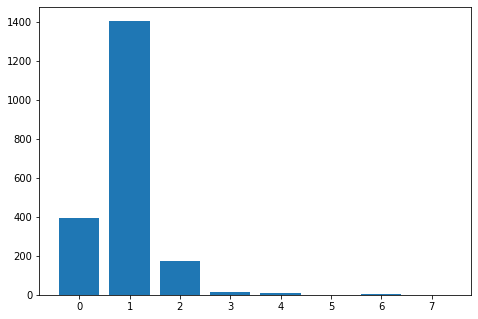

[394, 1407, 172, 16, 8, 0, 2, 1]


In [11]:
# Testing Dataset Statistics: showing the number of spans in one example
test_distribution = [len(_contiguous_ranges(test_spans[i])) for i in range(len(test_spans))]
test_freq=[(len([item for item in test_distribution if  i == item ])) for i in range(max(test_distribution)+1)]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([i for i in range(len(test_freq))],test_freq)
plt.show()
print(test_freq)

# B. Dataset Setup and Models



## B1. Dataset

In [12]:
# Dataset Setup, with torch.utils.data.Dataset
class TSDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, index):
        item = {key: torch.tensor(val[index]) for key, val in self.X.items()}
        item['labels'] = torch.tensor(self.y[index])
        return item

    def __len__(self):
        return len(self.y)

## B2. Tokenization on Toxicity

In [13]:
def tokenization(tokenizer, texts, spans):
    text_embeddings = tokenizer(texts, return_offsets_mapping=True, padding=True, truncation=True)
    labels = []
    for i, span in enumerate(spans):
        label = []
        for j in range(len(text_embeddings[i].tokens)):
            label.append(0)
        toxic_indices = set(span)
        for j, offset in enumerate(text_embeddings[i].offsets):
            if offset == (0, 0):
                # When the label is CLS, SEP and PAD then set to -99.
                label[j] = -100
            else:
                for k in range(offset[0], offset[1]):
                    if k in toxic_indices: 
                        # When the token is toxic then label to 1.
                        label[j] = 1
                        break
        labels.append(label)
    return text_embeddings, labels

##B3. Data Augmentation

In [14]:
pip install numpy requests nlpaug

In [15]:
import nlpaug.augmenter.char as nac

from nlpaug.util import Action

In [16]:
def substitute_char(text):
    aug = nac.RandomCharAug(action="substitute")
    augmented_text = aug.augment(text)
    return augmented_text

def swap_char(text):
    aug = nac.RandomCharAug(action="swap")
    augmented_text = aug.augment(text)
    return augmented_text

In [17]:
augmented = False

if augmented:
    new_train_texts = train_texts
    new_train_spans = train_spans
    for i in range(len(train_texts)):
        if (random.random() > 0.8):
            new_text = substitute_char(train_texts[i])
            new_text = swap_char(train_texts[i])
            new_span = train_spans[i]
            new_train_texts.append(new_text)
            new_train_spans.append(new_span)
    train_texts, train_spans = new_train_texts, new_train_spans

## B4. Model Selection

In [18]:
from transformers import DistilBertTokenizerFast, DistilBertForTokenClassification
from transformers import RobertaTokenizerFast, RobertaForTokenClassification
from transformers import GPT2TokenizerFast, GPT2ForSequenceClassification
from transformers import BertForTokenClassification, Trainer, TrainingArguments, BertTokenizerFast 

In [19]:
# Model 1: BERT-base
#tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
#model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=2)
#model.cuda()

# Model 2: RoBERTa base

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
model = RobertaForTokenClassification.from_pretrained("roberta-base", num_labels=2)
model.cuda()

# Model 3: DistilBERT

#tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-cased")
#model = DistilBertForTokenClassification.from_pretrained("distilbert-base-cased", num_labels=2)
#model.cuda()

# Get the word embeddings
train_text_embeddings, train_labels = tokenization(tokenizer, train_texts, train_spans)
val_text_embeddings, val_labels = tokenization(tokenizer, val_texts, val_spans)
test_text_embeddings, test_labels = tokenization(tokenizer, test_texts, test_spans)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

In [20]:
# Create Torch Dataset Objects for train / valid sets
train_dataset = TSDetectionDataset(train_text_embeddings, train_labels)
val_dataset = TSDetectionDataset(val_text_embeddings, val_labels)
test_dataset = TSDetectionDataset(test_text_embeddings, test_labels)

print(train_text_embeddings[10])

Encoding(num_tokens=423, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


In [21]:
train_offset_mapping = train_text_embeddings.pop("offset_mapping") 
val_offset_mapping = val_text_embeddings.pop("offset_mapping")
test_offset_mapping = test_text_embeddings.pop("offset_mapping")

# C. Training

## C1. F1 Score Evaulation

In [22]:
def toxic_character_offsets_with_thresholding(post_num, tokens, offset_mapping, prediction, val_sentences_info, prediction_score, threshold):
  toxic_offsets = []
  scores = []
  n = len(tokens)
  i = 1           # start from 1 as 0th token is [CLS]
  while i < n:
    # stop looping after processing all post tokens
    if tokens[i] == '[SEP]':
      break

    cur_toxic = []
    # if previous token is also predicted toxic, then toxic phrase found
    if len(toxic_offsets) > 0 and toxic_offsets[-1] == offset_mapping[i-1][1] - 1:
      cur_toxic.extend([index for index in range(offset_mapping[i-1][1], offset_mapping[i][0])])
    
    # add the characters offsets of this head BPE
    cur_toxic.extend([index for index in range(offset_mapping[i][0], offset_mapping[i][1])])
    cur_score = [(tokens[i], prediction_score[i].max())]
    cur_labels = [prediction[i]]
    
    # process all sub-tokens of the current head BPE
    i += 1
    while i < n and '##' in tokens[i]:
      cur_toxic.extend([index for index in range(offset_mapping[i][0], offset_mapping[i][1])])
      cur_score.append((tokens[i], prediction_score[i].max()))
      cur_labels.append(prediction[i])
      i += 1
    
    # word is predicted toxic if any sub-token is predicted toxic by model
    prediction_label = True if max(cur_labels) == 1 else False
    # prediction_label = True if min(cur_labels) == 1 else False

    
    # include cur_toxic offsets if any of the sub-token confidence score is greater than threshold
    confidence_values = [score for _, score in cur_score]
    passed_threshold = True if max(confidence_values) >= threshold else False
    # passed_threshold = True if min(confidence_values) >= threshold else False

    # include to global toxic offsets list only if both predicted label and threshold criteria passes
    if prediction_label and passed_threshold:
      toxic_offsets.extend(cur_toxic)
      scores.extend(cur_score)
  

  return toxic_offsets, scores

def character_offsets_with_thresholding(val_text_embeddings, val_offset_mapping, predictions, val_sentences_info, prediction_scores, threshold=-float('inf')):
  return [toxic_character_offsets_with_thresholding(i, val_text_embeddings[i].tokens, offset_mapping, prediction, val_sentences_info, prediction_scores[i], threshold) for i, (offset_mapping, prediction) in enumerate(zip(val_offset_mapping, predictions))]

In [28]:
# Referenced by SemEval 2021 Task Organizers' Sample Code: https://github.com/ipavlopoulos/toxic_spans

def avg_F1(toxic_char_preds, gold_char_offsets):

  def F1(predictions, gold):
    if len(gold) == 0:
        if len(predictions) == 0:
            return 1 
        else:
            return 0

    if len(predictions) == 0:
        return 0
    
    nom = 2*len(set(predictions).intersection(set(gold)))
    denom = len(set(predictions))+len(set(gold))

    return float(nom/denom)

  f1_scores = [F1(toxic_offsets, gold_offsets) for toxic_offsets, gold_offsets in zip(toxic_char_preds, gold_char_offsets)]

  return np.array(f1_scores).mean(axis=0)

metrics = defaultdict(list)
# custom metric wrapper function
def custom_metrics(pred):
    # get the sub-token predictions made by the model
    predictions = pred.predictions.argmax(-1)
    prediction_scores = pred.predictions

    threshold = 0.4
    # retrieve the toxic character offsets of these predictions
    toxic_char_preds_object = character_offsets_with_thresholding(val_text_embeddings, val_offset_mapping, predictions, val_sentences_info, prediction_scores, threshold)
    toxic_char_offsets = [span[0] for span in toxic_char_preds_object]

    # compute the precision, recall and f1 score on the validation set
    f1 = avg_F1(toxic_char_offsets, val_spans)

    temp = {'f1': f1}

    metrics['f1'].append(temp)

    return temp

## C2. Hyperparameters and Trainer Setup

In [24]:
epochs = 2
batch_size = 16
decay_rate = 0.01
learning_rate = 5e-5

training_args = TrainingArguments(
  output_dir="./checkpoints",                   
  num_train_epochs=2,
  per_device_train_batch_size=batch_size,  
  per_device_eval_batch_size=batch_size,
  warmup_steps=500,
  weight_decay=decay_rate,             
  logging_dir='./logs',
  logging_steps=5,
  do_eval=True,
  evaluation_strategy="steps",
  learning_rate=learning_rate,
  disable_tqdm=True,
)

trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_dataset,       
  eval_dataset=val_dataset,         
  compute_metrics=custom_metrics
)

val_sentences_info = {}

## C3. Training Time and Prediction

In [25]:
trainer.train()

# use trained model to make predictions on dev and test datasets
val_pred = trainer.predict(val_dataset)
test_pred = trainer.predict(test_dataset)

{'loss': 0.7788, 'learning_rate': 5.000000000000001e-07, 'epoch': 0.01}
{'eval_loss': 0.7730773091316223, 'eval_f1': 0.11152353114245818, 'eval_runtime': 6.3454, 'eval_samples_per_second': 108.74, 'epoch': 0.01}
{'loss': 0.7717, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.02}
{'eval_loss': 0.7504338026046753, 'eval_f1': 0.0950451405027317, 'eval_runtime': 6.1185, 'eval_samples_per_second': 112.773, 'epoch': 0.02}
{'loss': 0.7306, 'learning_rate': 1.5e-06, 'epoch': 0.03}
{'eval_loss': 0.7131667733192444, 'eval_f1': 0.0659694753350029, 'eval_runtime': 6.1046, 'eval_samples_per_second': 113.03, 'epoch': 0.03}
{'loss': 0.6919, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.04}
{'eval_loss': 0.6637511253356934, 'eval_f1': 0.05102837069764753, 'eval_runtime': 6.1093, 'eval_samples_per_second': 112.942, 'epoch': 0.04}
{'loss': 0.6414, 'learning_rate': 2.5e-06, 'epoch': 0.05}
{'eval_loss': 0.6034311652183533, 'eval_f1': 0.047101300594721125, 'eval_runtime': 6.0757, 'eval_samples_p

# D. Results 

## D1. Prediction Evaulation



In [ ]:
def compute_metrics(pred, gold_char_offsets, val_offset_mapping, val_text_embeddings, val_sentences_info, threshold=-float('inf')):
  predictions = pred.predictions.argmax(-1)
  prediction_scores = pred.predictions

  toxic_char_preds_object = character_offsets_with_thresholding(val_text_embeddings, val_offset_mapping, predictions, val_sentences_info, prediction_scores, threshold)
  toxic_char_offsets = [span[0] for span in toxic_char_preds_object]

  f1 = system_f1(toxic_char_offsets, gold_char_offsets)

  return {'f1': f1}

In [29]:
print("> Making Predictions on Test Set")

# Print final metrics
val_results = compute_metrics(val_pred, val_spans, val_offset_mapping, val_text_embeddings, val_sentences_info, threshold=0.4)
test_results = compute_metrics(test_pred, test_spans, test_offset_mapping, test_text_embeddings, val_sentences_info, threshold=0.4)
print(f'\n> Dev Scores: {val_results}')
print(f'\n> Test Scores: {test_results}')

> Making Predictions on Test Set

> Dev Scores: {'f1': 0.6642386734848162}

> Test Scores: {'f1': 0.6945823264888661}
